In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from lmfit.models import ExpressionModel
import numpy as np
%matplotlib widget

In [2]:
data = pd.read_excel("../data/raw/lattice_parameters.xlsx")
refdata = pd.read_csv("../data/external/ref_data.csv", names=["pressure(GPa)", "volume(A^3)", "phase"], skiprows=1)

In [3]:
data.head()

,pressure(GPa),a(A),esd_a,c(A),esd_c,vol(A^3),esd_vol,phase,file_no
0,0.0,3.009682,0.000334,20.889203,0.003259,163.868,0.024,166,1
1,3.6,2.998665,0.000639,20.768160,0.008181,161.728,0.063,166,2
2,12.0,2.979991,0.000487,20.624416,0.007187,158.614,0.057,166,3
3,24.0,2.951677,0.000639,20.403757,0.006564,153.950,0.058,166,4
4,31.0,2.930334,0.000486,20.306385,0.006775,151.007,0.054,166,5


In [4]:
refdata.head()

,pressure(GPa),volume(A^3),phase
0,0.292832,27.430168,166
1,1.317718,27.318436,166
2,2.928256,27.175873,166
3,5.739386,27.006041,166
4,7.964862,26.827270,166


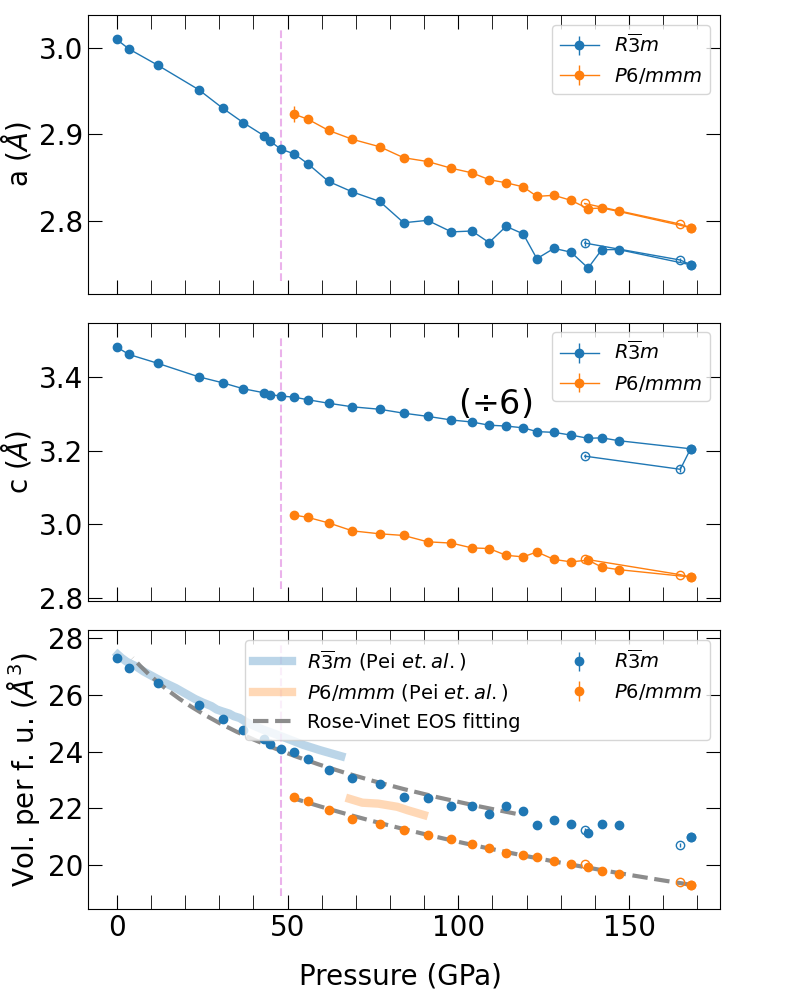

In [5]:
font_dict = {"label": 20, "text": 24, "legend":14, "tick": 10, "ticklabel": 18}
text = "($\div$6)"
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 10))
param_dict = {ax1: "a(A) esd_a a ($\AA$)", ax2: "c(A) esd_c c ($\AA$)", ax3: "vol(A^3) esd_vol Vol. per f. u. ($\AA^3$)"}
phase_dict = {166: "$R\overline{3}m$ C0 161.936217 28.0258621667 8.70716346", 191: "$P6/mmm$ C1 347.742249 25.0273216 4.90257289"}

for ax in {ax1, ax2, ax3}:
    params = param_dict[ax].split()
    for phase in {166, 191}:
        phases = phase_dict[phase].split()
        if (phase==166) & (ax!=ax1):
            fac = 6  
        else:
            fac = 1
        df = data[(data["phase"] == phase)]
        ax.errorbar(df["pressure(GPa)"][:-2], df[params[0]][:-2]/fac, yerr=df[params[1]][:-2]/fac, marker="o", label=phases[0], 
                    c=phases[1], linewidth=0 if ax==ax3 else 1, elinewidth=1)
        ax.errorbar(df["pressure(GPa)"][-3:], df[params[0]][-3:]/fac, yerr=df[params[1]][-3:]/fac, marker="o", markerfacecolor="None", 
                    c=phases[1], linewidth=0 if ax==ax3 else 1, elinewidth=1)
        if ax==ax3:
            B_0, V_0, B_0d = [float(num) for num in phases[2:]]
            refdf = refdata[refdata["phase"] == phase]
            ax.plot(refdf["pressure(GPa)"], refdf["volume(A^3)"], linewidth=6, alpha=0.3, c=phases[1], label=phases[0]+" (Pei "+"$\it{et. al.)}$")
            V = np.linspace(df[params[0]][:-11 if phase==166 else -2].min()/fac, df[params[0]].max()/fac, 20)
            predicted_pressure = 3 * B_0 * (1 - (V / V_0) ** (1 / 3)) / (V / V_0) ** (2 / 3) * np.exp(3 * (1 - (V / V_0) ** (1 / 3)) * (B_0d - 1) / 2)
            ax.plot(predicted_pressure, V, c="gray", linestyle="dashed", linewidth=3, alpha=0.9, label=None if phase==166 else "Rose-Vinet EOS fitting")
        ax.legend(ncol=2 if ax==ax3 else 1, fontsize=font_dict["legend"])
    if ax==ax2:
        ax.text(100, 3.3, text, fontsize=font_dict["text"])
    ax.vlines(48, ax.get_ylim()[0], ax.get_ylim()[1], linestyle="dashed", color="m", alpha=0.3)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(top=True, right=True, which="both", direction="in", size=font_dict["tick"], labelsize=font_dict["label"])
    ax.set_ylabel(" ".join(params[2:]), fontsize=font_dict["label"])
fig.supxlabel("Pressure (GPa)", fontsize=font_dict["label"])
plt.tight_layout()
plt.subplots_adjust(left=0.11, right=0.9)
# plt.savefig("../publication_ready/lattice_parameters.pdf")

In [5]:
df166 = data[data["phase"]==166]
df191 = data[data["phase"]==191]

In [15]:
mask = (df166["a(A)"].diff()>0) == False

model = ExpressionModel("3 * B_0 * (1 - (x / V_0)**(1/3)) / (x / V_0)**(2/3)"
                        " * exp(3 * (1 - (x / V_0)**(1/3)) * (B_0d - 1) / 2)")
params = model.make_params(B_0=300, B_0d=2.1, V_0=170)
# output = model.fit(df166["pressure(GPa)"][mask], params, x=df166["vol(A^3)"][mask])
output = model.fit(df166["pressure(GPa)"][:-11], params, x=df166["vol(A^3)"][:-11])
print(output.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 19
    # variables        = 3
    chi-square         = 90.9368051
    reduced chi-square = 5.68355032
    Akaike info crit   = 35.7487909
    Bayesian info crit = 38.5821078
    R-squared          = 0.99538671
[[Variables]]
    B_0:   274.109007 +/- 30.0532844 (10.96%) (init = 300)
    V_0:   164.730318 +/- 0.98741261 (0.60%) (init = 170)
    B_0d:  4.75196645 +/- 0.74581036 (15.69%) (init = 2.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(B_0, B_0d) = -0.959
    C(B_0, V_0)  = -0.914
    C(V_0, B_0d) = 0.772


fitting on 166, varying the fitting data range
[:-11]
[[Variables]]
    B_0:   274.109007 +/- 30.0532844 (10.96%) (init = 300)
    V_0:   164.730318 +/- 0.98741261 (0.60%) (init = 170)
    B_0d:  4.75196645 +/- 0.74581036 (15.69%) (init = 2.1)
    
[:-2] 
[[Variables]]
    B_0:   161.935004 +/- 67.7736538 (41.85%) (init = 300)
    V_0:   168.155247 +/- 4.57190724 (2.72%) (init = 170)
    B_0d:  8.70719576 +/- 1.73606970 (19.94%) (init = 2.1)


In [8]:
model = ExpressionModel("3 * B_0 * (1 - (x / V_0)**(1/3)) / (x / V_0)**(2/3)"
                        " * exp(3 * (1 - (x / V_0)**(1/3)) * (B_0d - 1) / 2)")
params = model.make_params(B_0=400, B_0d=4.5, V_0=25)
output = model.fit(df191["pressure(GPa)"][:-2], params, x=df191["vol(A^3)"][:-2])
print(output.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 19
    # variables        = 3
    chi-square         = 27.0688564
    reduced chi-square = 1.69180353
    Akaike info crit   = 12.7249527
    Bayesian info crit = 15.5582696
    R-squared          = 0.99864167
[[Variables]]
    B_0:   347.742205 +/- 51.7694680 (14.89%) (init = 400)
    V_0:   25.0273218 +/- 0.27481857 (1.10%) (init = 25)
    B_0d:  4.90257348 +/- 0.69437693 (14.16%) (init = 4.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(B_0, V_0)  = -0.993
    C(B_0, B_0d) = -0.992
    C(V_0, B_0d) = 0.970


fitting on 191
[[Variables]]
    B_0:   347.742205 +/- 51.7694680 (14.89%) (init = 400)
    V_0:   25.0273218 +/- 0.27481857 (1.10%) (init = 25)
    B_0d:  4.90257348 +/- 0.69437693 (14.16%) (init = 4.5)

TiB2: BT0 = 256.7 GPa,  B’T0 = 3.83. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5198855/

Plots for refinement

In [14]:
from pathlib import Path
data_dict, reflec_dict = {}, {}
for file in Path("../data/raw").iterdir():
    if "data" in file.name:
        data = pd.read_csv(file)
        data_dict[file.name[:2]] = data[data["y_calc"] > 0]
    if "reflec" in file.name:
        reflec_dict[file.name[:2]] = pd.read_csv(file)
data_dict, reflec_dict = (dict(sorted(_dict.items())) for _dict in (data_dict, reflec_dict))
print(data_dict.keys(), "\n", reflec_dict.keys())

dict_keys(['01', '17', '28']) 
 dict_keys(['01', '17', '28'])


In [15]:
data_dict["01"].head()

,x,y_obs,weight,y_calc,y_bkg,Q
89,3.00995,163.174,0.006128,162.417,162.331,0.798721
90,3.02895,163.591,0.006113,162.561,162.470,0.803761
91,3.04795,163.803,0.006105,162.683,162.585,0.808801
92,3.06696,163.274,0.006125,162.784,162.679,0.813844
93,3.08596,163.278,0.006125,162.865,162.752,0.818884


In [16]:
reflec_dict["01"].head()

,h,k,l,d-sp,2-theta,F_obs,F_calc,phase,mult,sig,gam,FWHM,Prfo,phase #
0,0,0,3,6.96307,3.407,1895.567,1729.996,0,2,0.02625,0.03397,0.08162,0.2287,0
1,0,0,6,3.48153,6.812,34219.424,33866.798,180,2,0.02622,0.06405,0.10262,0.2533,0
2,1,0,1,2.58640,9.172,35371.996,35491.345,0,6,0.02665,0.08496,0.11948,1.0600,0
3,1,0,-2,2.52891,9.381,11604.090,11225.951,0,6,0.02671,0.08682,0.12105,1.1875,0
4,1,0,4,2.33213,10.174,7541.210,5316.494,180,6,0.02695,0.09386,0.12710,0.6403,0


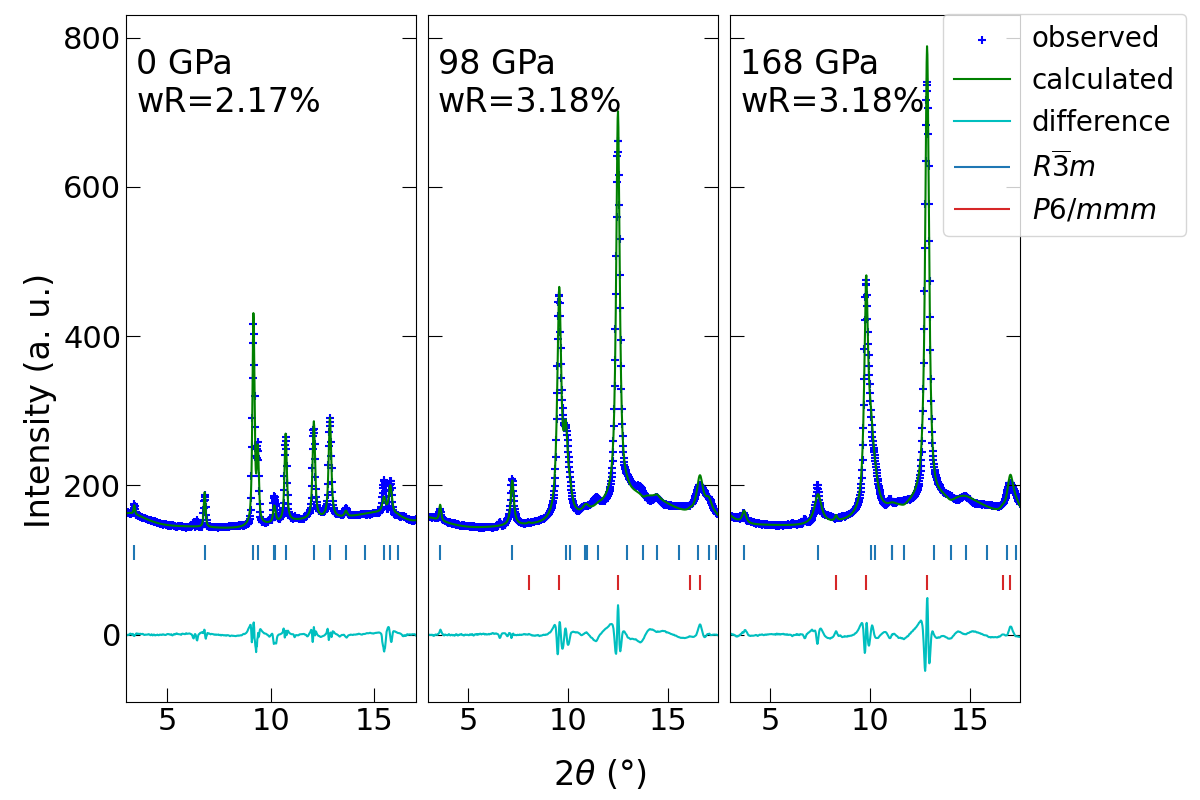

In [82]:
font_dict = {"label": 24, "text": 24, "legend":20, "tick": 10, "ticklabel": 22}
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 8))
text_dict = {ax1: "0 GPa"+"\n"+"wR=2.17%", ax2: "98 GPa"+"\n"+"wR=3.18%", ax3: "168 GPa"+"\n"+"wR=3.18%"}
plot_dict = {ax1: "01", ax2: "17", ax3: "28"}
for ax in {ax1, ax2, ax3}:
    data = data_dict[plot_dict[ax]]
    ax.scatter(data["x"], data["y_obs"], marker="+", label="observed", c="b")
    ax.plot(data["x"], data["y_calc"], label="calculated", c="g")
    ax.plot(data["x"], data["y_calc"]-data["y_obs"], label="difference", c="c")
    ax.set_xlim([data["x"].min(), data["x"].max()])
    reflec = reflec_dict[plot_dict[ax]]
    ax.vlines(reflec["2-theta"][reflec["phase #"]==0], 100, 120, label="$R\overline{3}m$", color="tab:blue")
    ax.vlines(reflec["2-theta"][reflec["phase #"]==1], 60, 80, label="$P6/mmm$", color="tab:red")
    ax.text(3.5, 700, text_dict[ax], fontsize=font_dict["text"])
    ax.tick_params(right=True, direction="in", size=font_dict["tick"], labelsize=font_dict["ticklabel"])
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=font_dict["legend"])
fig.supxlabel(r"2$\theta$" " " r"$(\degree)$", fontsize=font_dict["label"])
fig.supylabel("Intensity (a. u.)", fontsize=font_dict["label"])
plt.tight_layout()
plt.subplots_adjust(right=0.85)
# plt.savefig("../publication_ready/refinement.pdf")